In [2]:
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git-repos/floto-federated-knowledge-distillation


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.optimize import minimize

def calculate_angular_difference(angle, pt_angle):
    """Calculate the difference between two angles."""
    return min(abs(angle - pt_angle), 360 - abs(angle - pt_angle))


def calculate_total_angular_difference(rotation, star_angles, point_angles):
    """Calculate the total angular difference."""
    total_difference = 0
    for pt_angle in point_angles:
        min_difference = min([calculate_angular_difference(angle + rotation, pt_angle) for angle in star_angles])
        total_difference += min_difference
    return total_difference


def calculate_equal_angular_difference(rotation, star_angles, point_angles):
    """Calculate the variance of angular differences."""
    differences = []
    for pt_angle in point_angles:
        min_difference = min([calculate_angular_difference(angle + rotation, pt_angle) for angle in star_angles])
        differences.append(min_difference)
    return np.std(differences)


def combined_objective_function(rotation, star_angles, point_angles, total_weight = 0.5):
    equal_diff = calculate_equal_angular_difference(rotation, star_angles, point_angles)
    total_diff = calculate_total_angular_difference(rotation, star_angles, point_angles)
    
    max_total_diff = 180 * len(point_angles)
    normalized_total_diff = total_diff / max_total_diff
    normalized_equal_diff = equal_diff / 180
        
    return total_weight * normalized_total_diff + (1-total_weight) * normalized_equal_diff


def orientation(p1, p2, p3):
    """Returns positive if points are counterclockwise, negative if clockwise, and 0 if collinear"""
    v1 = np.array([p2[0]-p1[0], p2[1]-p1[1], 0])
    v2 = np.array([p3[0]-p2[0], p3[1]-p2[1], 0])
    cross_product = np.cross(v1, v2)
    return cross_product[2]


def create_circle(pts: np.array):
    points = pts[:3]

    A = points[0]
    B = points[1]
    C = points[2]

    a = np.linalg.norm(C - B)
    b = np.linalg.norm(C - A)
    c = np.linalg.norm(B - A)

    s = (a + b + c) / 2

    R = a*b*c / 4 / np.sqrt(s * (s - a) * (s - b) * (s - c))

    b1 = a*a * (b*b + c*c - a*a)
    b2 = b*b * (a*a + c*c - b*b)
    b3 = c*c * (a*a + b*b - c*c)
    P = np.column_stack((A, B, C)).dot(np.hstack((b1, b2, b3)))
    center = P / (b1 + b2 + b3)

    v1 = B - A
    v1 /= np.linalg.norm(v1) 
    v2 = np.cross(np.cross(B - A, C - A), v1)
    v2 /= np.linalg.norm(v2) 
    
    return {"center": center, "radius": R, "v1": v1, "v2": v2}


def create_circles_from_dict(input_dict):
    circles_by_location = {}
    for location, patients in input_dict.items():
        circles = []
        for patient in patients:

            pts_gt = np.array([patient['RCC'], patient['LCC'], patient['ACC'], patient['RCA'], patient['LCA']])

            points_dict = {key: point for key, point in zip(['RCC', 'LCC', 'ACC'], pts_gt[:3])}
            circle = create_circle(pts_gt)
            
            circle['r_d'] = np.linalg.norm(pts_gt[3] - pts_gt[0])
            circle['l_d'] = np.linalg.norm(pts_gt[4] - pts_gt[1])
            circle['points'] = points_dict
            
            circles.append(circle)

        circles_by_location[location] = circles
    return circles_by_location


def plot_circles_fl(circles_fl):
    fig, axs = plt.subplots(1, 1, figsize=(30, 7.5))

    # sns.set()
    # sns.set_style('whitegrid')

    color_dict = {'RCC': 's', 'LCC': '^', 'ACC': 'o'}
    
    # cmap_by_location = {
    #     'greifswald': plt.cm.get_cmap("Reds"),
    #     'frankfurt': plt.cm.get_cmap("Blues"),
    #     'goettingen': plt.cm.get_cmap("Greens"),
    #     'muenster': plt.cm.get_cmap("Purples"),
    #     'munich': plt.cm.get_cmap("Greys"),
    #     'heidelberg': plt.cm.get_cmap("Oranges"),
    # }
    colors = sns.color_palette()
    
    all_rotations = []
    all_x = []
    all_y = []
    cbar_axes = []
    
    all_distances = []
    for location, circles in circles_fl.items():
        r_distances = [circle['r_d'] for circle in circles]
        l_distances = [circle['l_d'] for circle in circles]
        all_distances.extend(r_distances)
        all_distances.extend(l_distances)
        
    min_dist = min(all_distances)
    max_dist = max(all_distances)
    range_dist = max_dist - min_dist

    
    for idx, (location, circles) in enumerate(circles_fl.items()):
        color = colors[idx % len(colors)]
        max_R = 0
        for i, circle in enumerate(circles):
            center = circle["center"]
            R = circle["radius"]
            v1 = circle["v1"]
            v2 = circle["v2"]
            pts = circle["points"]
            
            
            if R>max_R:
                max_R = R
                
            # Plot the circle
            theta = np.linspace(0, 2*np.pi, 100)
            x = R * np.cos(theta)
            y = R * np.sin(theta)
            all_x.append(x)
            all_y.append(y)
            axs.plot(x, y, color='black', alpha=0.3, linewidth=0.1)

            # Project points on aa plane
            pts_angles = []
            pts_projected = []
            for pt_name, pt in pts.items():
                pt_new = np.dot(pt - center, v1), np.dot(pt - center, v2)
                angle = np.degrees(np.arctan2(pt_new[1], pt_new[0]))
                pts_angles.append(angle)
                pts_projected.append(pt_new)
                
            bisector_pts = [(np.array(pts_projected[i]) + np.array(pts_projected[(i+1)%3]))/2 for i in range(3)]
            for i, bisector_pt in enumerate(bisector_pts):
                p_next = bisector_pts[(i+1)%3]
                p_prev = bisector_pts[i]
                
                if orientation(np.array([0, 0]), p_prev, p_next) < 0:
                    bisector_pts[(i+1)%3] = -bisector_pts[(i+1)%3]
            
            bisector_angles = []
            for pt in bisector_pts:
                angle = np.degrees(np.arctan2(pt[1], pt[0]))
                bisector_angles.append(angle)
            
            # Create fitted bisectors and rotate projected points
            star_angles = [-90, 30, 150]
            total_weight = 0.5
            rcc_bi_angle, lcc_bi_angle, acc_bi_angle = [], [], []
            result = minimize(fun=combined_objective_function, x0=0, args=(bisector_angles, star_angles, total_weight))
            rotation = result.x[0]
            for bi_angle, (pt_name,_), pt_proj, pt_angle  in zip(bisector_angles,pts.items(), pts_projected, pts_angles):
                bi_angle += rotation
                all_rotations.append(rotation)
                start_x = 0
                start_y = 0
                end_x = R * np.cos(np.radians(bi_angle))
                end_y = R * np.sin(np.radians(bi_angle))
                plt.plot([start_x, end_x], [start_y, end_y], 'k-', linewidth=0.1, alpha=0.3)
                
                pt_angle += rotation
                x = R * np.cos(np.radians(pt_angle))
                y = R * np.sin(np.radians(pt_angle))
                
                if pt_name == "RCC":
                    alpha_val = (circle['r_d'] - min_dist) / range_dist
                    rcc_bi_angle.append(bi_angle)
                elif pt_name == "LCC":
                    alpha_val = (circle['l_d'] - min_dist) / range_dist
                    lcc_bi_angle.append(bi_angle)
                else:
                    alpha_val = 0.5
                    acc_bi_angle.append(bi_angle)
                    
                marker = color_dict.get(pt_name, 'o')
                if location == 'FedKDSWIN-UNETR':
                    alpha_val = 1.0
                    color = 'red'
                axs.scatter(x, y, color=color, marker=marker)#, alpha=alpha_val)
                
        
    for star_angle in star_angles:
        end_x = max_R * np.cos(np.radians(star_angle))
        end_y = max_R * np.sin(np.radians(star_angle))
        axs.plot([0, end_x], [0, end_y], color='black', alpha=1.)
    
    median_angles = np.median([rcc_bi_angle, lcc_bi_angle, acc_bi_angle], axis=1)
    median_angles_names = ['RCC/LCC Median','LCC/ACC Median','ACC/RCC Median']
    # for median, name, star_angle in zip(median_angles, median_angles_names,star_angles):
    #     end_x = max_R * np.cos(np.radians(median))
    #     end_y = max_R * np.sin(np.radians(median))
    #     axs.plot([0, end_x], [0, end_y], color='magenta', linestyle='dashed', label=f'{name} = {median-star_angle:.1f} °')
        
        
    for median, name, star_angle in zip(median_angles, median_angles_names, star_angles):
        end_x = max_R * np.cos(np.radians(median))
        end_y = max_R * np.sin(np.radians(median))
        axs.plot([0, end_x], [0, end_y], color='magenta', linestyle='dashed')

        # Adding annotation
        text_angle = (median + star_angle) / 2  # Midpoint angle for the text
        text_x = max_R * 1.2 * np.cos(np.radians(text_angle))  # x-coordinate
        text_y = max_R * 1.2 * np.sin(np.radians(text_angle))  # y-coordinate

        axs.annotate(f'{median-star_angle:.1f} °',
                    xy=(end_x, end_y), xycoords='data',
                    xytext=(text_x, text_y), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3,rad=.2",
                                    facecolor='black', 
                                    edgecolor='black',),
                    fontsize=10, color='black')
        
        
        
    median_x = np.median(np.array(all_x), axis=0)
    median_y = np.median(np.array(all_y), axis=0)
    axs.plot(median_x, median_y, label=f'Median = {max(median_x)-min(median_x):.1f} mm', color='magenta', linestyle='dashed')

    axs.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

    
    axs.set_xlabel("mm")
    axs.set_ylabel("mm")
    
    # axs.set_facecolor('white')
    
    #cax = fig.add_axes([0.62, 0.08 , 0.012, 0.9])
    #norm = plt.Normalize(min(all_distances), max(all_distances))
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap("Greys"), norm=norm)
    #sm.set_array([])
    #cbar = plt.colorbar(sm, cax=cax)
    #cbar.set_label('LCC to LCA / RCC to RCA Distance (mm)')
    
    axs.legend()
    
    legend1_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[idx % len(colors)], markersize=10, linestyle='None') for idx in range(len(circles_fl))]

    loc_numbers = {
        1: 'Heidelberg', 2: 'Munich', 3: 'Muenster', 4: 'Goettingen', 5: 'Berlin', 6: 'Frankfurt', 7: 'Hamburg', 8: 'Greifswald', 9: 'FedKDSWIN-UNETR'
    }
    
    labels = [key.capitalize() for key in circles_fl.keys()]
    labels[-1] = 'FedKDSWIN-UNETR'
    labels = [[f'L{k}' for k, v in loc_numbers.items() if v == l][0] for l in labels]
    labels[-1] = 'FedKDSWIN-UNETR'
    legend1_handles[-1] = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, linestyle='None')
    legend1 = axs.legend(handles=legend1_handles, labels=labels, loc='upper right', framealpha=0.3)
    axs.add_artist(legend1)
    
    legend2_handles = [plt.Line2D([0], [0], marker=marker, color='black', linestyle='None') for pt_name, marker in color_dict.items()]
    # custom_lines = [Line2D([0], [0], color='magenta', linestyle='dashed', label=f'{name} = {median-star_angle:.1f} °') for median, name, star_angle in zip(median_angles, median_angles_names, star_angles)]
    extra_line = [Line2D([0], [0], color='magenta', linestyle='dashed', label=f'Median diameter = {max(median_x)-min(median_x):.1f} mm')]

    combined_handles = legend2_handles + extra_line
    combined_labels = list(color_dict.keys()) + [f'Median diameter = {max(median_x)-min(median_x):.1f} mm']
    axs.legend(handles=combined_handles, labels=combined_labels, loc='upper left', framealpha=0.3)

    # combined_handles = legend2_handles + custom_lines + extra_line
    # combined_labels = list(color_dict.keys()) + [f'{name} = {median-star_angle:.1f} °' for median, name, star_angle in zip(median_angles, median_angles_names, star_angles)] + [f'Median = {max(median_x)-min(median_x):.1f} mm']
    # axs.legend(handles=combined_handles, labels=combined_labels, loc='upper left', framealpha=0.3)

    axs.set_aspect('equal')
    plt.tight_layout()
    
    # plt.show()
    return fig


In [58]:
from pathlib import Path
from src.utils import pts_from_mps

public_pts_human = {}

src = Path('/mnt/hdd/data/FLOTO_ImageCas_Subset')
# locs = ['Frankfurt', 'Hamburg', 'Muenster', 'Greifswald', 'Berlin', 'Heidelberg']
locs = ['Heidelberg', 'Munich', 'Muenster', 'Goettingen', 'Berlin', 'Franfurt', 'Hamburg', 'Greifswald']

pts_labels = ['RCC', 'LCC', 'ACC', 'RCA', 'LCA']
# for pts_path in src.glob('*/*.mps'):
for loc in locs:
    for pts_path in (src /'Human' / loc).glob('*.mps'):
    # loc = pts_path.parent.name
        if loc not in locs:
            continue
        if loc not in public_pts_human:
            public_pts_human[loc] = []
        subject = pts_path.stem
        pts = pts_from_mps(pts_path)
        if loc == 'Greifswald':
            pts = pts[[1,0,2,4,3]]
        if pts.shape[0] < 5:
            continue
        public_pts_human[loc].append({l: pt for l, pt in zip(pts_labels, pts)})

public_pts_human['FedKDSWIN-UNETR'] = []
for pts_path in (src / 'Federated_UNet').glob('*.mps'):
    subject = pts_path.stem
    pts = pts_from_mps(pts_path)
    if pts.shape[0] < 5:
        continue
    public_pts_human['FedKDSWIN-UNETR'].append({l: pt for l, pt in zip(pts_labels, pts)})

In [59]:
public_pts_human.keys()

dict_keys(['Heidelberg', 'Muenster', 'Berlin', 'Hamburg', 'Greifswald', 'FedKDSWIN-UNETR'])

In [60]:
from pathlib import Path
import seaborn as sns
sns.set()
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from federated import NAME_TO_NODE_ID

def get_tb_metrics(tb_logdir):
    tb_logdir /= 'tb_logs'
    test_metrics = {}
    for node_tb_logdir in tb_logdir.iterdir():
        node_name = [k for k, v in NAME_TO_NODE_ID.items() if v == node_tb_logdir.name]
        if len(node_name) == 0:
            node_name = 'heidelberg'
        else:
            node_name = node_name[0]
        test_metrics[node_name] = {}
        ea = EventAccumulator(str(node_tb_logdir))
        ea.Reload()
        for tb_scalar in ea.Tags()['scalars']:
            test_metrics[node_name][tb_scalar.replace('VALIDATION ON GLOBAL UPDATES/', '')] = [x.value for x in ea.Scalars(tb_scalar)]
            #print(np.array([[x.step, x.wall_time, x.value] for x in ea.Scalars(tb_scalar)]))
    return test_metrics

In [61]:
hps_exp_path = 'experiments/federated/hps_pred/1714048598.982399'
metrics = get_tb_metrics(Path(hps_exp_path))

In [62]:
pts_labels = ['RCC', 'LCC', 'ACC', 'RCA', 'LCA']
hps_gt, hps_pred = {}, {}
for loc, loc_m in metrics.items():
    hps_gt[loc] = []
    hps_pred[loc] = []
    for i in range(len(loc_m['RCC_x_gt'])):
        hps_gt[loc].append({
            l: [loc_m[f'{l}_x_gt'][i], loc_m[f'{l}_y_gt'][i], loc_m[f'{l}_z_gt'][i]]
            for l in pts_labels
        })
        hps_pred[loc].append({
            l: [loc_m[f'{l}_x_pred'][i], loc_m[f'{l}_y_pred'][i], loc_m[f'{l}_z_pred'][i]]
            for l in pts_labels
        })

In [63]:
hps_gt = {l: hps_gt[l.lower()] for l in locs if l.lower() in hps_gt}
hps_pred = {l: hps_pred[l.lower()] for l in locs if l.lower() in hps_pred}

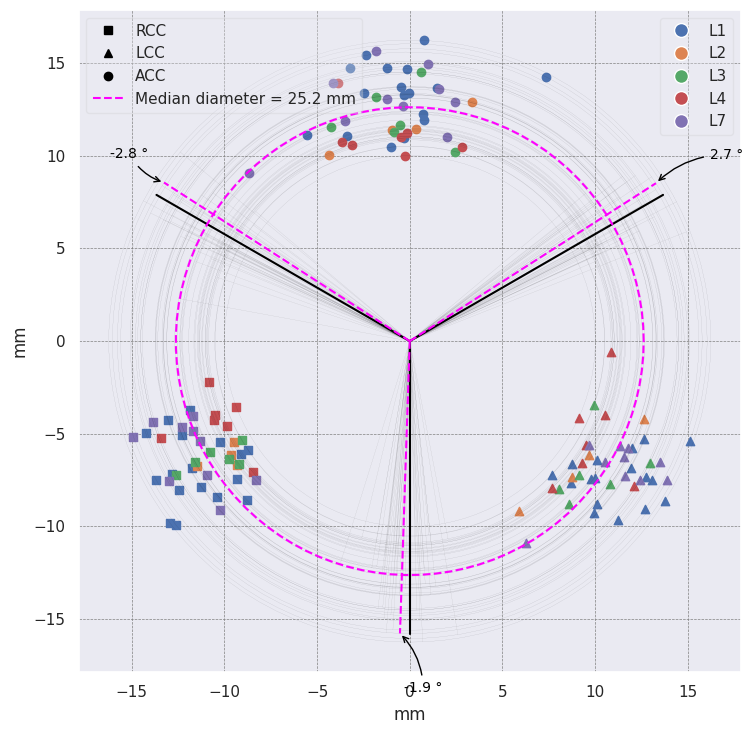

In [64]:
circles_fl = create_circles_from_dict(hps_gt)
fig = plot_circles_fl(circles_fl)
fig.savefig('notebooks/images/hps_constraints_gt.png', bbox_inches='tight')

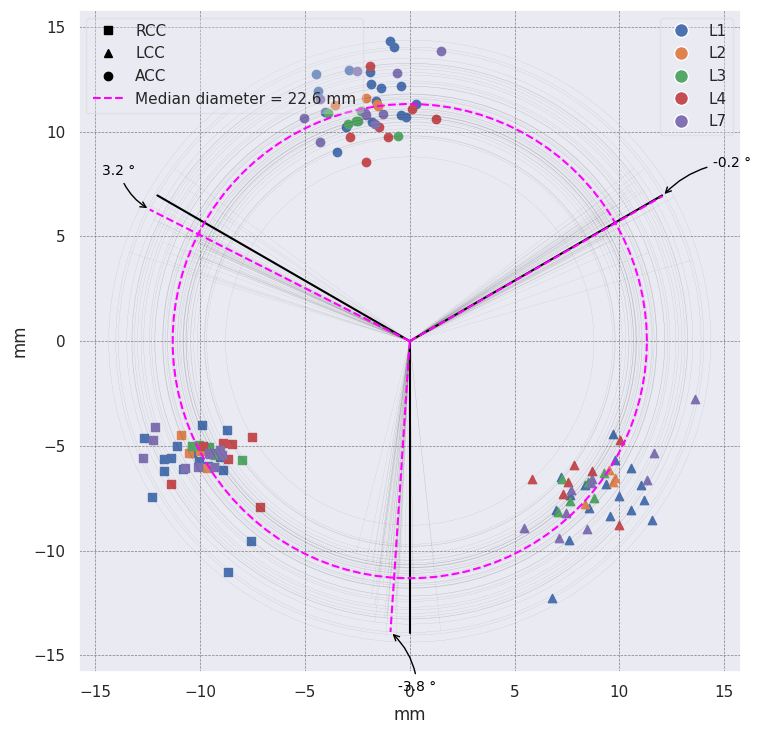

In [66]:
circles_fl = create_circles_from_dict(hps_pred)
fig = plot_circles_fl(circles_fl)
fig.savefig('notebooks/images/hps_constraints_pred.png', bbox_inches='tight')

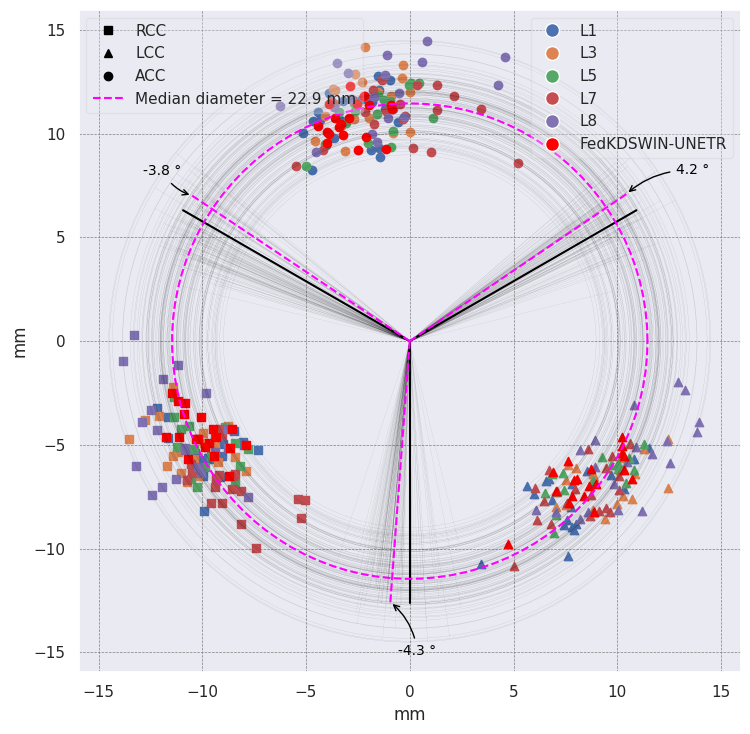

In [70]:
import seaborn as sns
sns.set()
circles_fl = create_circles_from_dict(public_pts_human)
fig = plot_circles_fl(circles_fl)
fig.tight_layout()
fig.savefig('public_dataset_hps_circle.png', bbox_inches='tight')